<a href="https://colab.research.google.com/github/dsiervo/ICTP_EQ_tutorials/blob/master/gds_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [71]:
!pip install obspy

In [72]:
import pandas as pd
from obspy.geodetics import degrees2kilometers
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import plotly.express as px
import os
import glob

sns.set(style="whitegrid", font_scale=1.4)
%matplotlib inline

# Load Data

In [73]:
main_path = '/content/drive/My Drive/statistical analysis'
aut_pub = '/content/drive/My Drive/statistical analysis/EDA GDS/datos_publicaciones_gds.csv'
# publicación manual de los que no se publicarían
man_no_pub = '/content/drive/My Drive/statistical analysis/EDA GDS/localizacion_manual_de_los_q_no_se_publicarian.csv'
# publicaciones con error en profundidad mayor a 10
err_10 ='/content/drive/My Drive/statistical analysis/EDA GDS/publicaciones_gds_error_mayor_10.csv'
# sismos que no se publicarían (no existe origen con errores < 10)
no_pub = '/content/drive/My Drive/statistical analysis/EDA GDS/sismos_que_no_se_publicarian.csv'
# sismos que si se publicarían (existe origen con errores < 10)
si_pub = '/content/drive/My Drive/statistical analysis/EDA GDS/time_spam_event_to_well_public.csv'


In [74]:
df_all = pd.read_csv(aut_pub)
df_all.rename({'convert(cast(convert(region using latin1) as binary) using utf8)':'region'},
              inplace=True, axis=1)
df_man_no = pd.read_csv(man_no_pub)
df_err_10 = pd.read_csv(err_10)
df_aut_no = pd.read_csv(no_pub)
df_si_pub = pd.read_csv(si_pub)
df_si_pub.rename({'convert(cast(convert(region using latin1) as binary) using utf8)':'region'},
              inplace=True, axis=1)
df_err_10.rename({'convert(cast(convert(region using latin1) as binary) using utf8)':'region'},
              inplace=True, axis=1)
df_err_10.head(3)

,event_id,author,revision,service,timestamp,origin_time,magnitude,latitude,lat 232,latitude_uncertainty,longitude,lon 232,longitude_uncertainty,depth,depth 232,depth_uncertainty,region,evaluationMode
0,SGC2018qtxx,gds,9,email_automatico_internacional,2018-08-27 14:16:39,2018-08-27 14:14:25,4.23848,5.2699,5.2699,3.384531,-73.7095,-73.7095,6.478073,168.326,168.3263,11.603910,"Lenguazaque - Cundinamarca, Colombia",automatic
1,SGC2018wofa,gds,11,email_automatico_internacional,2018-11-17 20:16:35,2018-11-17 20:13:48,4.01936,8.4180,8.4180,6.929646,-71.9308,-71.9308,6.929646,4.390,4.3900,14.700000,Venezuela,automatic
2,SGC2018ykwtw,gds,5,email_automatico_internacional,2018-12-14 09:58:36,2018-12-14 09:56:04,4.92185,-3.1248,-3.1248,3.662284,-75.5769,-75.5769,4.772066,115.956,115.9559,61.298862,Northern Peru,automatic


In [75]:
region = df_all.loc[11].region
print(region.lower())

caribbean sea


In [76]:
'murindó' in region.lower()

False

In [77]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 225 entries, 0 to 224
Data columns (total 18 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   event_id               225 non-null    object 
 1   author                 225 non-null    object 
 2   revision               225 non-null    int64  
 3   service                225 non-null    object 
 4   timestamp              225 non-null    object 
 5   origin_time            225 non-null    object 
 6   magnitude              225 non-null    float64
 7   latitude               225 non-null    float64
 8   lat 232                225 non-null    float64
 9   latitude_uncertainty   225 non-null    float64
 10  longitude              225 non-null    float64
 11  lon 232                225 non-null    float64
 12  longitude_uncertainty  225 non-null    float64
 13  depth                  225 non-null    float64
 14  depth 232              225 non-null    float64
 15  depth_

# EDA
## Data Engeniering
We want to answer these questions:
* What portion of publications have depth error above 10?
  * Whish of those events would have been published any way?
    * After which time?
  * Whish of those events are Pacific or Caribbean?

In [78]:
n = len(df_all)
n_err_10 = len(df_err_10)

df_all['err_prof_ma_10'] = df_all['depth_uncertainty'] >= 10
df_err_10['err_prof_ma_10'] = df_err_10['depth_uncertainty'] >= 10

n_si_pub = len(df_si_pub)
n_no_pub = len(df_aut_no)

In [79]:
mylist = ['pacific ', ' pacífico', 'océano ', 'caribbean ', ' caribe', 'coast']

pattern = '|'.join([f'(?i){reg}' for reg in mylist])
print(pattern)

n_pac_car = df_all['region'].str.contains(pattern).sum()

df_all['pac_car'] = df_all['region'].str.contains(pattern)
df_all['pac_car'] = df_all['pac_car'].apply(lambda x: 'Pacífico o Caribe' if x else 'Interior')

df_err_10['pac_car'] = df_err_10['region'].str.contains(pattern)
df_err_10['pac_car'] = df_err_10['pac_car'].apply(lambda x: 'Pacífico o Caribe' if x else 'Interior')

df_all[['origin_time', 'revision', 'magnitude', 'region', 'pac_car', 'err_prof_ma_10']].head(3)

(?i)pacific |(?i) pacífico|(?i)océano |(?i)caribbean |(?i) caribe|(?i)coast


,origin_time,revision,magnitude,region,pac_car,err_prof_ma_10
0,2018-08-18 19:39:08,11,6.08996,Mar Caribe,Pacífico o Caribe,False
1,2018-08-22 13:06:23,10,4.54517,"Cimitarra - Santander, Colombia",Interior,False
2,2018-08-26 11:53:26,8,4.44531,Near Coast of Venezuela,Pacífico o Caribe,False


# Data Visualization

In [80]:
n_prof_pc = len(df_all.query('err_prof_ma_10 == True and pac_car == "Pacífico o Caribe"'))
n_prof_int = len(df_all.query('err_prof_ma_10 == True and pac_car != "Pacífico o Caribe"'))

"""n_pup_pc = len(df_si_pub.query('err_prof_ma_10 == True and pac_car == "Pacífico o Caribe"'))
n_pup_int = len(df_si_pub.query('err_prof_ma_10 == True and pac_car != "Pacífico o Caribe"'))

n_prof_int"""

'n_pup_pc = len(df_si_pub.query(\'err_prof_ma_10 == True and pac_car == "Pacífico o Caribe"\'))\nn_pup_int = len(df_si_pub.query(\'err_prof_ma_10 == True and pac_car != "Pacífico o Caribe"\'))\n\nn_prof_int'

In [81]:
#'Se publicarían después'
data = dict(
  items = ['Publicados', 'Err. prof > 10', 'Bien', 'Pacífico o Caribe', 'Interior'],
  parent = ['', 'Publicados', 'Publicados', 'Err. prof > 10', 'Err. prof > 10'],
  value = [n, n_err_10, n-n_err_10, n_prof_pc, n_prof_int]
)

fig =px.sunburst(
    data,
    names='items',
    parents='parent',
    values='value'
)
fig.show()

In [82]:
df_pub = pd.merge(df_err_10[['event_id', 'pac_car', 'err_prof_ma_10', 'revision']],
                  df_si_pub[['event_id', 'revision']],
                  on='event_id', how='left')

df_pub.fillna('no pub', inplace=True)
df_pub.head(2)

,event_id,pac_car,err_prof_ma_10,revision_x,revision_y
0,SGC2018qtxx,Interior,True,9,20
1,SGC2018wofa,Interior,True,11,no pub


In [83]:
n_sipub_pc = len(df_pub.query('revision_y != "no pub" and pac_car == "Pacífico o Caribe"'))
n_sipub_int = len(df_pub.query('revision_y != "no pub" and pac_car != "Pacífico o Caribe"'))

n_nopub_pc = len(df_pub.query('revision_y == "no pub" and pac_car == "Pacífico o Caribe"'))
n_nopub_int = len(df_pub.query('revision_y == "no pub" and pac_car != "Pacífico o Caribe"'))

In [84]:
data = dict(
  items = ['Publicados', 'Err. prof > 10', 'Bien', 'Se publicarían', 'No se publicarían',
           'Pacífico o Caribe', 'Interior', 'Pac o Car', 'Int'],
  parent = ['', 'Publicados', 'Publicados', 'Err. prof > 10', 'Err. prof > 10',
            'No se publicarían', 'No se publicarían', 'Se publicarían', 'Se publicarían'],
  value = [n, n_err_10, n-n_err_10, n_si_pub, n_no_pub, n_nopub_pc, n_nopub_int,
           n_sipub_pc, n_sipub_int]
)

fig =px.sunburst(
    data,
    names='items',
    parents='parent',
    values='value'
)
fig.show()

In [85]:
per_10 = 17/225*100
per_nopub = 10/225*100

print('Porcentaje err prof mayor a 10:', per_10)
print('Porcentaje no se publicarían:', per_nopub)

Porcentaje err prof mayor a 10: 7.555555555555555
Porcentaje no se publicarían: 4.444444444444445


# Find best depth error

In [86]:
def remove_outliers(column_name, df, alpha=0.015):
  print(column_name)
  y = df[column_name]
  removed_outliers = y.between(y.quantile(alpha), y.quantile(1-alpha))
  index_names = df[~removed_outliers].index
  print(index_names)
  return index_names

del_depth_idx = remove_outliers('depth_uncertainty', df_all)

try:
  df_all.drop(del_depth_idx, inplace=True)
except KeyError:
  pass
df_all.info()

depth_uncertainty
Int64Index([ 27,  39,  40,  42,  44,  45,  50,  54,  59,  89, 103, 114, 135,
            140, 150, 152, 163, 185, 187, 203, 207, 208, 211, 219, 220],
           dtype='int64')
<class 'pandas.core.frame.DataFrame'>
Int64Index: 200 entries, 0 to 224
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   event_id               200 non-null    object 
 1   author                 200 non-null    object 
 2   revision               200 non-null    int64  
 3   service                200 non-null    object 
 4   timestamp              200 non-null    object 
 5   origin_time            200 non-null    object 
 6   magnitude              200 non-null    float64
 7   latitude               200 non-null    float64
 8   lat 232                200 non-null    float64
 9   latitude_uncertainty   200 non-null    float64
 10  longitude              200 non-null    float64
 11  lon 232             

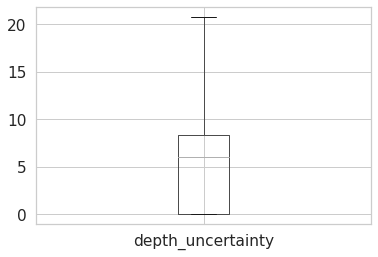

In [87]:
df_all.boxplot(column=['depth_uncertainty'])

Text(0, 0.5, 'Conteo')

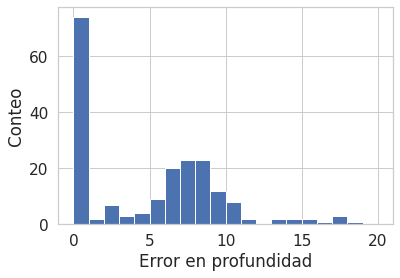

In [88]:
df_all['depth_uncertainty'].hist(bins=range(21), log=False)
#plt.grid(True, which='both')
plt.xlabel('Error en profundidad')
plt.ylabel('Conteo')

In [89]:
df_all_pub = pd.merge(df_all[['event_id', 'pac_car', 'err_prof_ma_10',
                              'revision', 'depth_uncertainty', 'magnitude',
                              'depth']],
                  df_si_pub[['event_id', 'revision']],
                  on='event_id', how='left')

df_all_pub.fillna('no pub', inplace=True)

df_all_pub['public'] = 'Se publicaría'
# I use eval instad of queary because is the right way to assing value base on query condition
df_all_pub.loc[df_all_pub.eval('revision_y == "no pub" and err_prof_ma_10 == True'), 'public'] = 'No se publicaría'
df_all_pub.head(2)

,event_id,pac_car,err_prof_ma_10,revision_x,depth_uncertainty,magnitude,depth,revision_y,public
0,SGC2018qdxc,Pacífico o Caribe,False,11,0.0,6.08996,10.0,no pub,Se publicaría
1,SGC2018qksd,Interior,False,10,0.0,4.54517,10.0,no pub,Se publicaría


Text(0.5, 6.8, 'Error en profundidad')

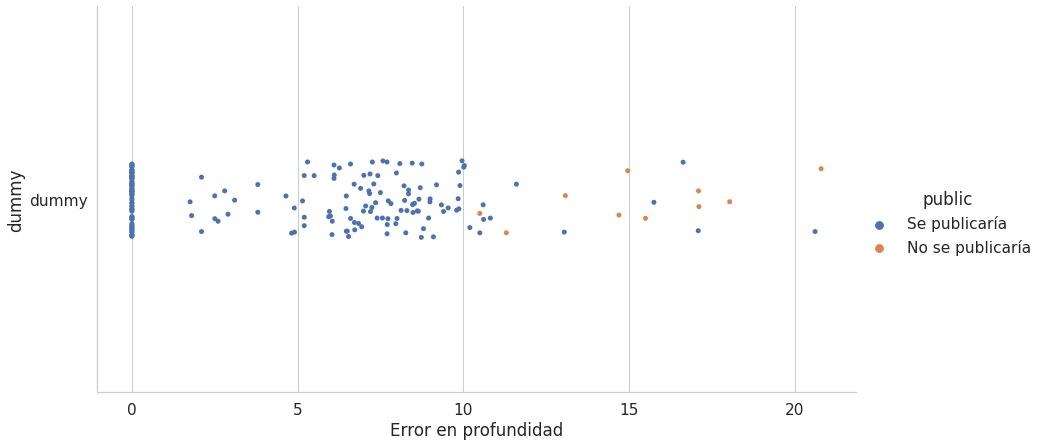

In [90]:
df_all_pub.loc[:,'dummy'] = 'dummy'

g = sns.catplot(x='depth_uncertainty', y='dummy', data=df_all_pub, 
                  height=6, aspect=2, hue='public')

plt.xlabel('Error en profundidad')
#plt.grid(True, which="both", ls="-", color='0.65')

In [91]:
def plot_rel(x, y, df, hue_style=None):
    sns.relplot(x=x, y=y, style=hue_style,
              hue=hue_style, data=df,
              aspect=1.8, s=200, alpha=0.6, height=8)
    #x = list(range(4, 8))
    #plt.plot(x,x, c='r')

def plot_reg(x, y, df, x_bins=None, x_ci='ci', robust=False):
    sns.regplot(x=x, y=y, data=df, x_bins=x_bins, robust=robust,
                x_ci='ci')

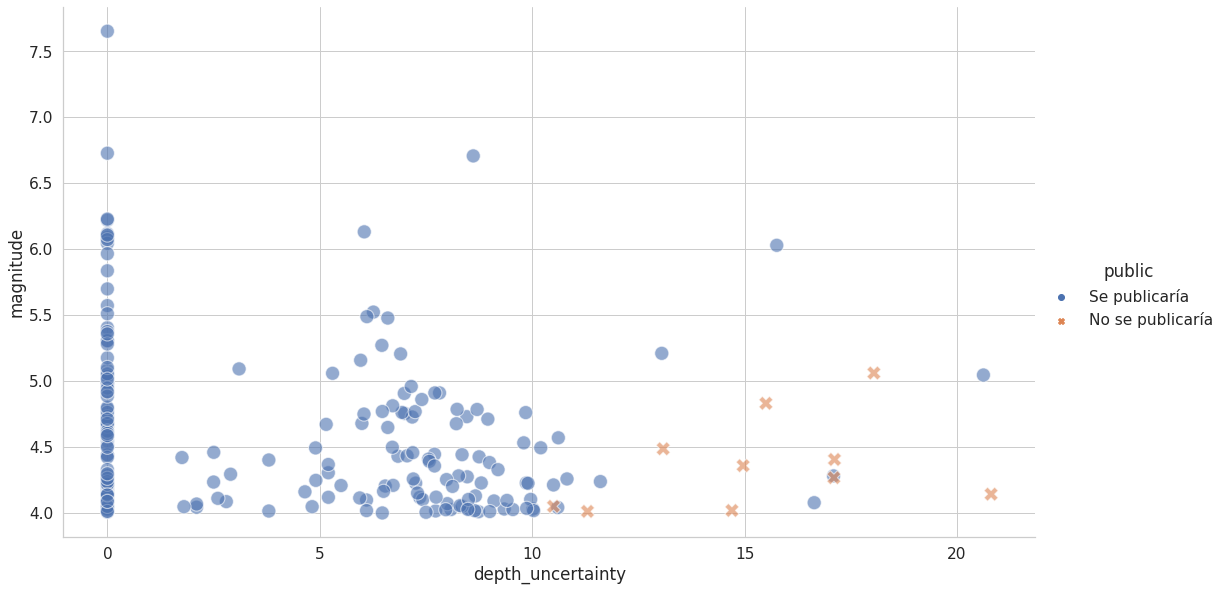

In [92]:
plot_rel('depth_uncertainty', 'magnitude', df_all_pub, hue_style='public')

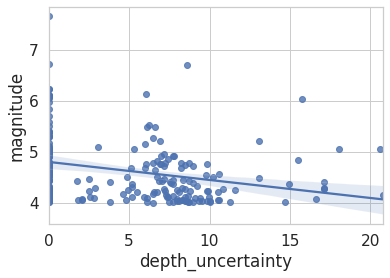

In [93]:
plot_reg('depth_uncertainty', 'magnitude', df_all_pub)

# Automatic vs Manual Comparison

df_auto and df_manual are the dataframes with the automatic and manual data for the publication of important events

In [94]:
auto_path = '/content/drive/My Drive/statistical analysis/EDA GDS/datos_publicaciones_gds2.csv'
manual_path = '/content/drive/My Drive/statistical analysis/EDA GDS/datos_localizaciones_manuales_gds.csv'

df_auto = pd.read_csv(auto_path)
df_auto.rename({'convert(cast(convert(region using latin1) as binary) using utf8)':'region'},
              inplace=True, axis=1)

df_manual = pd.read_csv(manual_path)
df_manual.rename({'convert(cast(convert(region using latin1) as binary) using utf8)':'region'},
              inplace=True, axis=1)

df_manual.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 213 entries, 0 to 212
Data columns (total 18 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   event_id               213 non-null    object 
 1   author                 213 non-null    object 
 2   revision               213 non-null    int64  
 3   service                213 non-null    object 
 4   timestamp              213 non-null    object 
 5   origin_time            213 non-null    object 
 6   magnitude              213 non-null    float64
 7   latitude               213 non-null    float64
 8   lat 232                213 non-null    float64
 9   latitude_uncertainty   213 non-null    float64
 10  longitude              213 non-null    float64
 11  lon 232                213 non-null    float64
 12  longitude_uncertainty  213 non-null    float64
 13  depth                  213 non-null    float64
 14  depth 232              213 non-null    float64
 15  depth_

### Merging the dataframes

In [95]:
# Identifing the Caribbean and Pacific events
n_pac_car = df_manual['region'].str.contains(pattern).sum()
df_manual['pac_car'] = df_manual['region'].str.contains(pattern)
df_manual['pac_car'] = df_manual['pac_car'].apply(lambda x: 'Pacífico o Caribe'\
                                                  if x else 'Interior')

# Identifing the automatic events with depth error above 10
df_auto['errp_10'] = df_auto['depth_uncertainty'] >= 10

# keepint with the columns of interest
df_manual = df_manual[['event_id', 'revision', 'origin_time', 'magnitude',
                       'latitude', 'latitude_uncertainty', 'longitude', 'pac_car',
                       'longitude_uncertainty', 'depth', 'depth_uncertainty', 'region']]

# keepint with the columns of interest
df_auto = df_auto[['event_id', 'revision', 'origin_time', 'magnitude', 
                  'latitude', 'latitude_uncertainty', 'longitude', 'errp_10',
                  'longitude_uncertainty', 'depth', 'depth_uncertainty']]

In [96]:
# The manual columns have the suffix _m and the automatic ones have _a
df_merge = pd.merge(df_manual, df_auto, on='event_id',
                    how='inner', suffixes=('_m', '_a'))
df_merge.dropna(inplace=True)
df_merge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 193 entries, 0 to 212
Data columns (total 22 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   event_id                 193 non-null    object 
 1   revision_m               193 non-null    int64  
 2   origin_time_m            193 non-null    object 
 3   magnitude_m              193 non-null    float64
 4   latitude_m               193 non-null    float64
 5   latitude_uncertainty_m   193 non-null    float64
 6   longitude_m              193 non-null    float64
 7   pac_car                  193 non-null    object 
 8   longitude_uncertainty_m  193 non-null    float64
 9   depth_m                  193 non-null    float64
 10  depth_uncertainty_m      193 non-null    float64
 11  region                   193 non-null    object 
 12  revision_a               193 non-null    int64  
 13  origin_time_a            193 non-null    object 
 14  magnitude_a              1

### Feature Engineering

In [97]:
# computing the difference in localization and magnitude
df_merge['dif_rad'] = degrees2kilometers(
    np.sqrt((df_merge['latitude_a']-df_merge['latitude_m'])**2\
            + (df_merge['longitude_a']-df_merge['longitude_m'])**2))

df_merge['dif_lat'] = degrees2kilometers(df_merge['latitude_a']-df_merge['latitude_m'])
df_merge['dif_lon'] = degrees2kilometers(df_merge['longitude_a']-df_merge['longitude_m'])
df_merge['dif_depth'] = df_merge['depth_a']-df_merge['depth_m']

df_merge['dif_lat_err'] = df_merge['latitude_uncertainty_a']-df_merge['latitude_uncertainty_m']
df_merge['dif_lon_err'] = df_merge['longitude_uncertainty_a']-df_merge['longitude_uncertainty_m']
df_merge['dif_depth_err'] = df_merge['depth_uncertainty_a']-df_merge['depth_uncertainty_m']

df_merge['dif_mag'] = df_merge['magnitude_a'] - df_merge['magnitude_m']

### Data Exploration

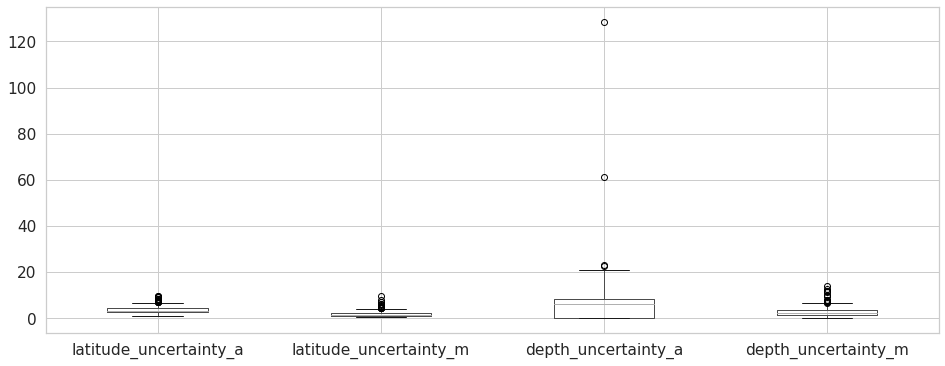

In [98]:
df_merge.boxplot(column=['latitude_uncertainty_a', 'latitude_uncertainty_m',
                         'depth_uncertainty_a', 'depth_uncertainty_m'],
                 figsize=(16,6))

Removing outliers, keeping with the events betweeen 1% to 99% in the distribution of depth_uncertainty_a

depth_uncertainty_a
Int64Index([36, 94], dtype='int64')


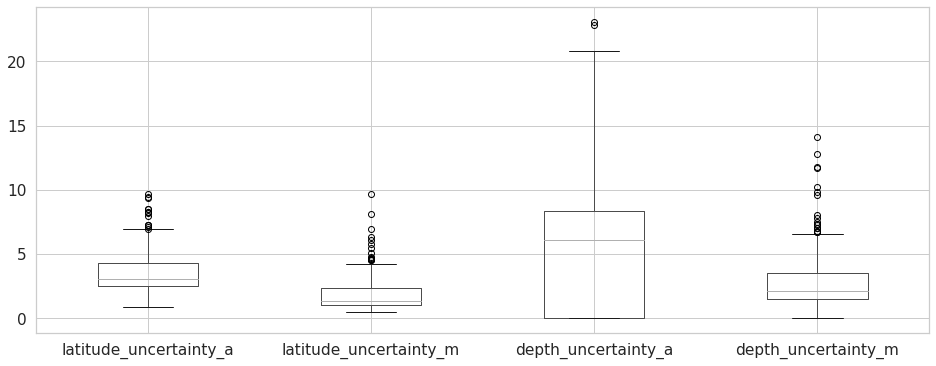

In [99]:
del_depth_idx = remove_outliers('depth_uncertainty_a', df_merge, 0.01)

try:
  df_merge.drop(del_depth_idx, inplace=True)
except KeyError:
  pass

df_merge.boxplot(column=['latitude_uncertainty_a', 'latitude_uncertainty_m',
                         'depth_uncertainty_a', 'depth_uncertainty_m'],
                 figsize=(16,6))

Text(0.5, 0, 'Error [km]')

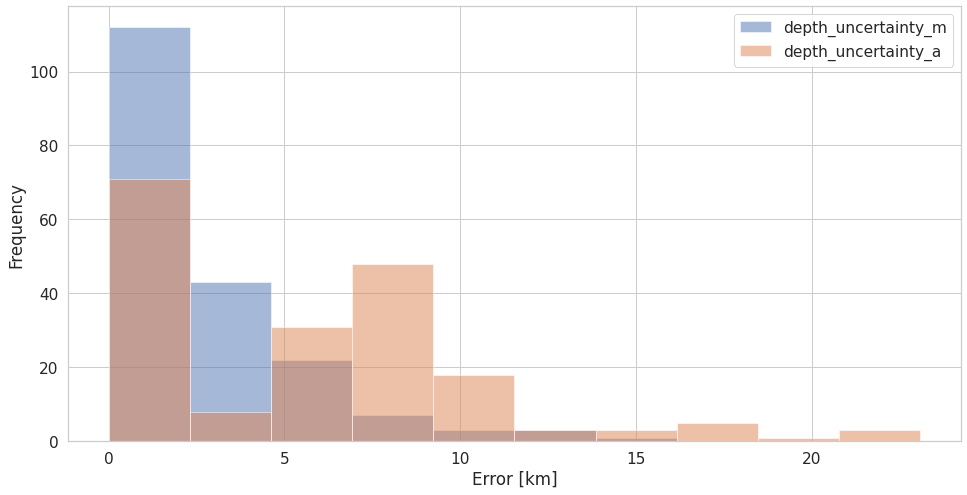

In [100]:
df_merge[['depth_uncertainty_m', 'depth_uncertainty_a']].plot.hist(
                                                       #bins=range(13),
                                                       alpha=0.5, 
                                                       figsize=(16, 8))
plt.xlabel('Error [km]')

Text(0.5, 0, 'Error [km]')

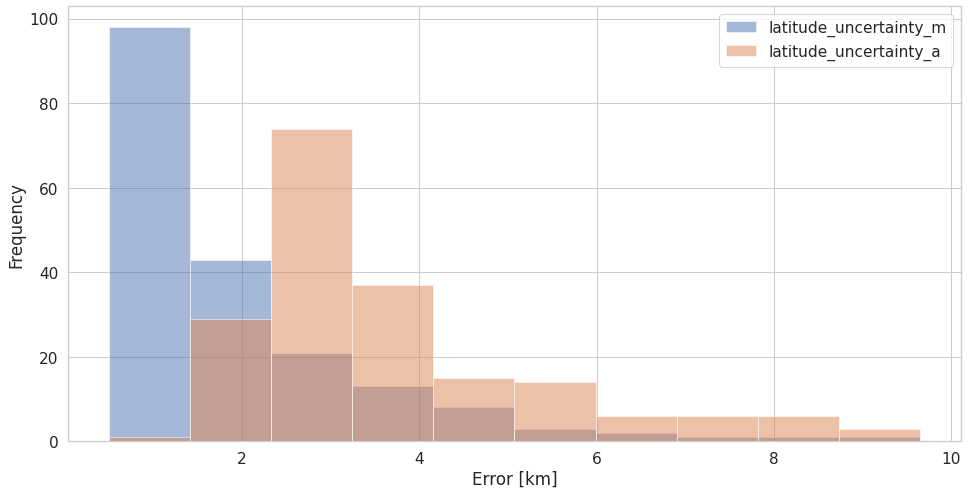

In [101]:
df_merge[['latitude_uncertainty_m', 'latitude_uncertainty_a']].plot.hist(
                                                       alpha=0.5, 
                                                       figsize=(16, 8))
plt.xlabel('Error [km]')

Text(0.5, 0, 'Magnitud [km]')

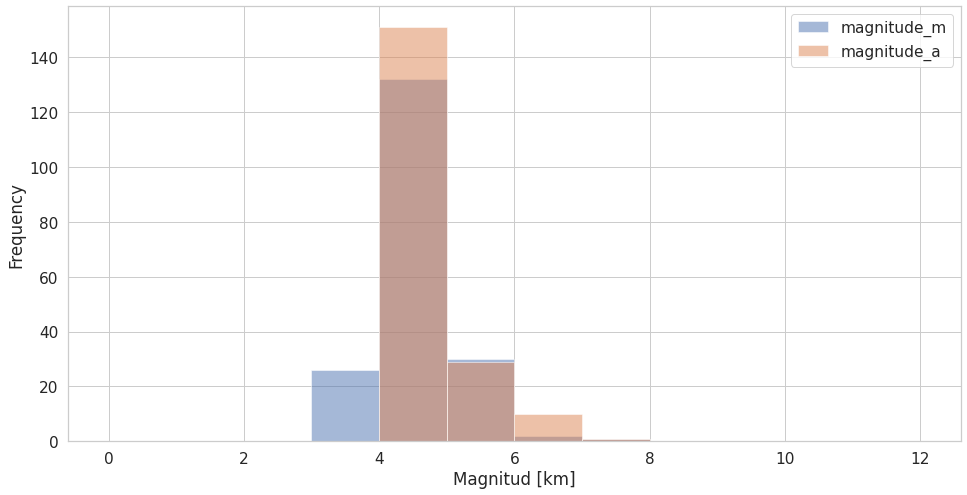

In [102]:
df_merge[['magnitude_m', 'magnitude_a']].plot.hist(
                                                       bins=range(13),
                                                       alpha=0.5, 
                                                       figsize=(16, 8))
plt.xlabel('Magnitud [km]')

### Data Analysis

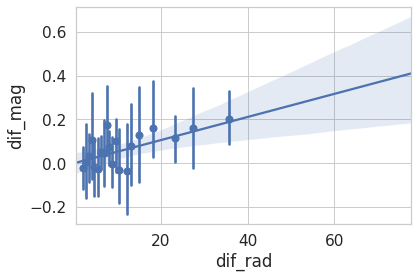

In [103]:
plot_reg('dif_rad', 'dif_mag', df_merge, x_bins=20)

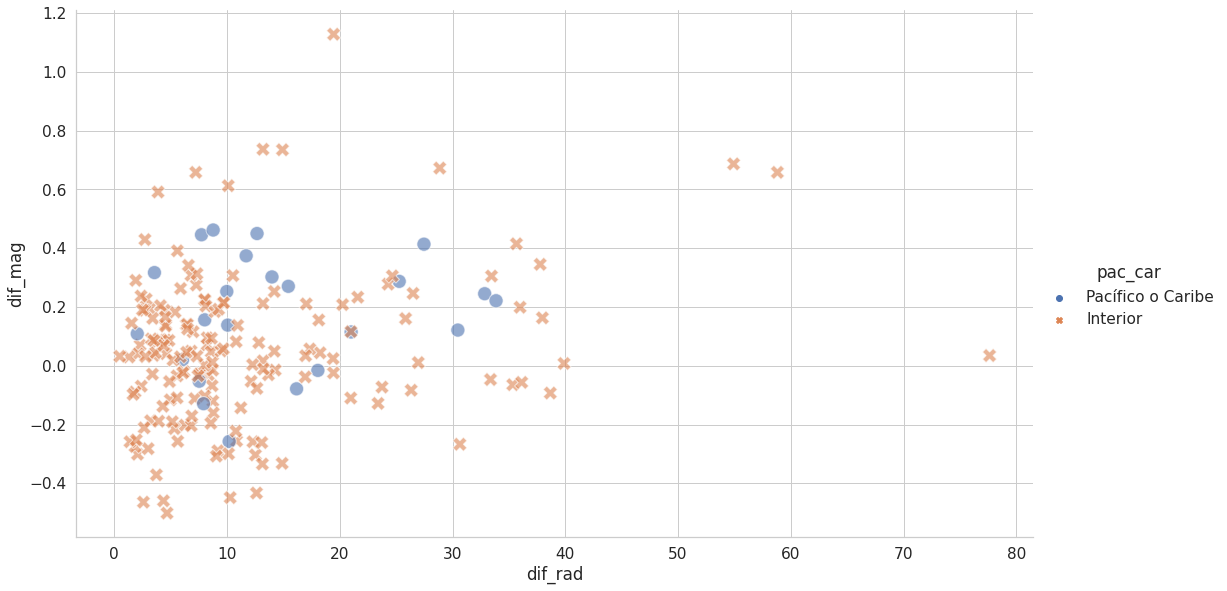

In [104]:
plot_rel('dif_rad', 'dif_mag', df_merge, 'pac_car')

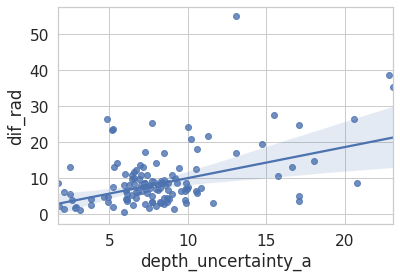

In [105]:
plot_reg('depth_uncertainty_a', 'dif_rad',
         df_merge[df_merge['depth_uncertainty_a']>0], x_bins=None,
         robust=True)

# Many Depth Uncernainty Threshold

### Load Data

In [106]:
data_dir = '/content/drive/My Drive/statistical analysis/EDA GDS/dif_depths_threshold/'

glob.glob(os.path.join(data_dir,'*.csv'))

['/content/drive/My Drive/statistical analysis/EDA GDS/dif_depths_threshold/sismos_que_se_publicarian_error10.csv',
 '/content/drive/My Drive/statistical analysis/EDA GDS/dif_depths_threshold/sismos_que_se_publicarian_error18.csv',
 '/content/drive/My Drive/statistical analysis/EDA GDS/dif_depths_threshold/sismos_que_se_publicarian_error19.csv',
 '/content/drive/My Drive/statistical analysis/EDA GDS/dif_depths_threshold/sismos_que_se_publicarian_error11.csv',
 '/content/drive/My Drive/statistical analysis/EDA GDS/dif_depths_threshold/sismos_que_se_publicarian_error14.csv',
 '/content/drive/My Drive/statistical analysis/EDA GDS/dif_depths_threshold/sismos_que_se_publicarian_error20.csv',
 '/content/drive/My Drive/statistical analysis/EDA GDS/dif_depths_threshold/sismos_que_se_publicarian_error13.csv',
 '/content/drive/My Drive/statistical analysis/EDA GDS/dif_depths_threshold/sismos_que_se_publicarian_error12.csv',
 '/content/drive/My Drive/statistical analysis/EDA GDS/dif_depths_thresh

In [128]:
def load_data(data_dir):
  d = {}
  data_list = glob.glob(os.path.join(data_dir,'*.csv'))

  cols = ['rad', 'mag', 'lat', 'lon', 'depth','size',
          'lat_err', 'lon_err', 'depth_err', 'unc',
          'rad_max', 'mag_max', 'depth_max']
  
  keys = []

  for col in cols:
    d[col] = []

  for path in data_list:
    key = path.split('.')[0][-2:]
    df_auto = pd.read_csv(path)
    # The manual columns have the suffix _m and the automatic ones have _a
    df_merge = pd.merge(df_manual, df_auto, on='event_id',
                        how='inner', suffixes=('_m', '_a'))
  
    df_merge.dropna(inplace=True)
    # computing the difference in localization and magnitude
    df_rad = degrees2kilometers(
        np.sqrt((df_merge['latitude_a']-df_merge['latitude_m'])**2\
                + (df_merge['longitude_a']-df_merge['longitude_m'])**2))
    dif_rad = df_rad.mean()
    rad_max = df_rad.max()
  
    size = len(df_auto)
    df_mag = df_merge['magnitude_a'] - df_merge['magnitude_m']
    dif_mag = df_mag.mean()
    mag_max = df_mag.max()
    dif_lat = degrees2kilometers(abs(df_merge['latitude_a']-df_merge['latitude_m'])).mean()
    dif_lon = degrees2kilometers(abs(df_merge['longitude_a']-df_merge['longitude_m'])).mean()
    df_depth = abs(df_merge['depth_a']-df_merge['depth_m'])
    dif_depth = df_depth.mean()
    depth_max = df_depth.max()
    dif_lat_err = (df_merge['latitude_uncertainty_a']-df_merge['latitude_uncertainty_m']).mean()
    dif_lon_err = (df_merge['longitude_uncertainty_a']-df_merge['longitude_uncertainty_m']).mean()
    dif_depth_err = (df_merge['depth_uncertainty_a']-df_merge['depth_uncertainty_m']).mean()

    # dataframe which contains all published data
    if key == "30":
      data = {'dif_mag':df_mag, 'dif_depth':df_depth,
              'dif_rad':df_rad}
      df_a = pd.concat(data, axis=1)
    else:
      # fill lists
      d['rad'].append(dif_rad)
      d['mag'].append(dif_mag)
      d['lat'].append(dif_lat)
      d['lon'].append(dif_lon)
      d['depth'].append(dif_depth)
      d['rad_max'].append(rad_max)
      d['mag_max'].append(mag_max)
      d['depth_max'].append(depth_max)
      d['lat_err'].append(dif_lat_err)
      d['lon_err'].append(dif_lon_err)
      d['depth_err'].append(dif_depth_err)
      d['unc'].append(int(key))
      d['size'].append(size)

  df = pd.DataFrame(data=d)
  return df, df_a
  #data_dic[key] = [dif_rad, dif_mag, dif_lat, dif_lon, dif_depth, dif_lat_err,
  #                dif_lon_err, dif_depth_err]

In [130]:
df, df_todos = load_data(data_dir)
df.head(2)

,rad,mag,lat,lon,depth,size,lat_err,lon_err,depth_err,unc,rad_max,mag_max,depth_max
0,11.889999,0.042366,7.181554,8.047352,16.039469,190,1.672097,2.093889,1.469073,10,77.635563,1.12829,140.66
1,12.275338,0.052946,7.599355,8.147709,16.382269,197,1.781587,2.260546,2.102447,18,77.635563,1.12829,141.05


In [134]:
df_todos.describe()

,dif_mag,dif_depth,dif_rad
count,193.000000,193.000000,193.000000
mean,0.063414,18.247958,12.347094
std,0.249249,26.352947,11.506443
min,-0.501070,0.000000,0.484432
25%,-0.083020,4.600000,4.861139
50%,0.045810,10.020000,8.600229
75%,0.204700,17.392000,14.893688
max,1.128290,141.050000,77.635563


Text(0.5, 6.8, 'Máxima incertidumbre en profundidad')

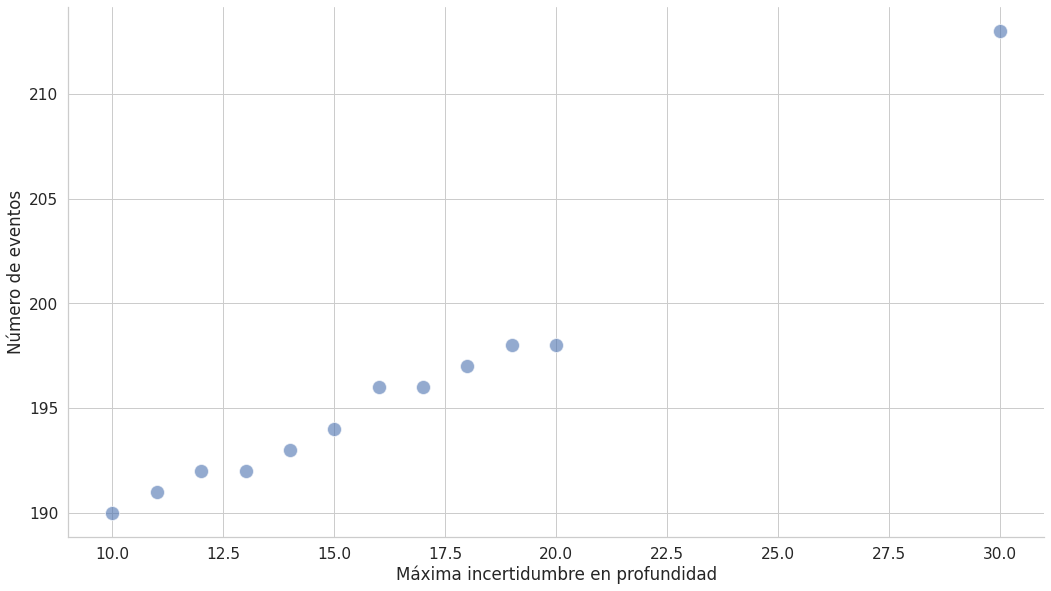

In [112]:
plot_rel('unc', 'size', df)
#sns.catplot(x='unc', y='size', data=df, color='b')

plt.ylabel('Número de eventos')
plt.xlabel('Máxima incertidumbre en profundidad')

Text(0.5, 6.8, 'Máxima incertidumbre en profundidad')

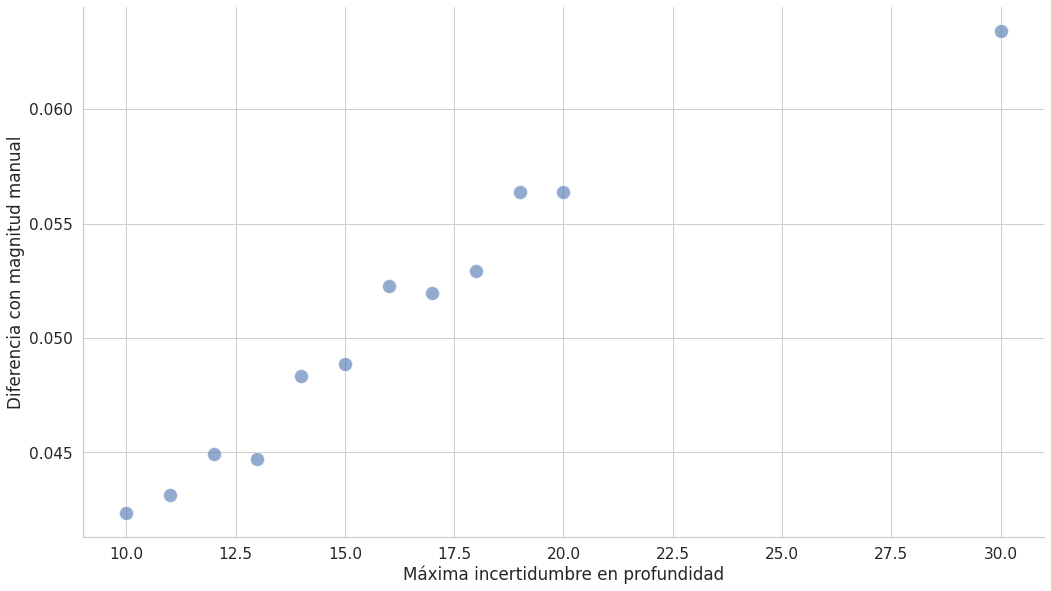

In [113]:
plot_rel('unc', 'mag', df)
plt.ylabel('Diferencia con magnitud manual')
plt.xlabel('Máxima incertidumbre en profundidad')

Text(0.5, 6.8, 'Máxima incertidumbre en profundidad')

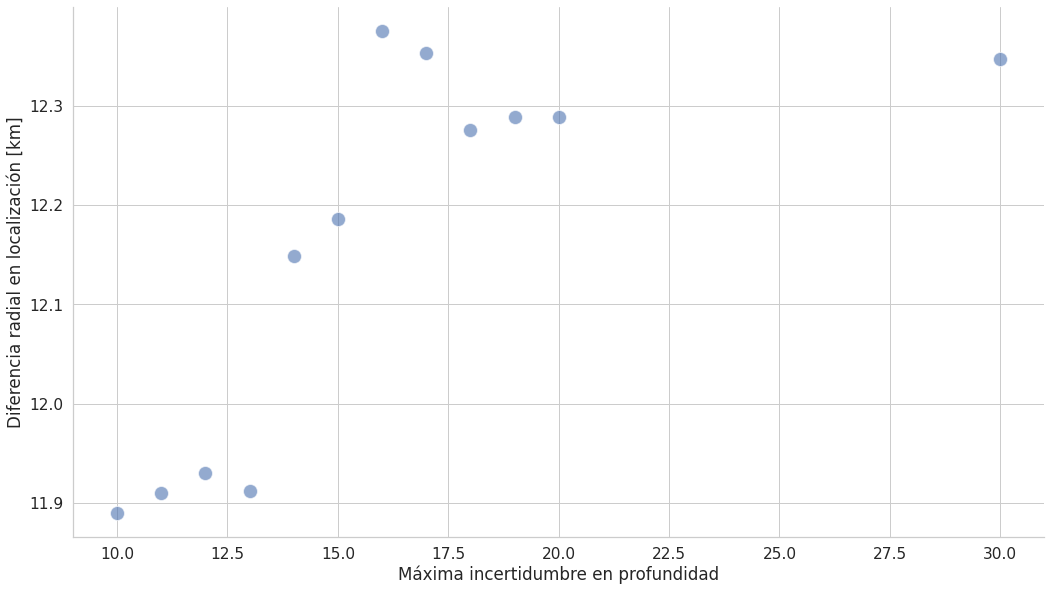

In [114]:
plot_rel('unc', 'rad', df)
plt.ylabel('Diferencia radial en localización [km]')
plt.xlabel('Máxima incertidumbre en profundidad')

Text(0.5, 6.8, 'Máxima incertidumbre en profundidad')

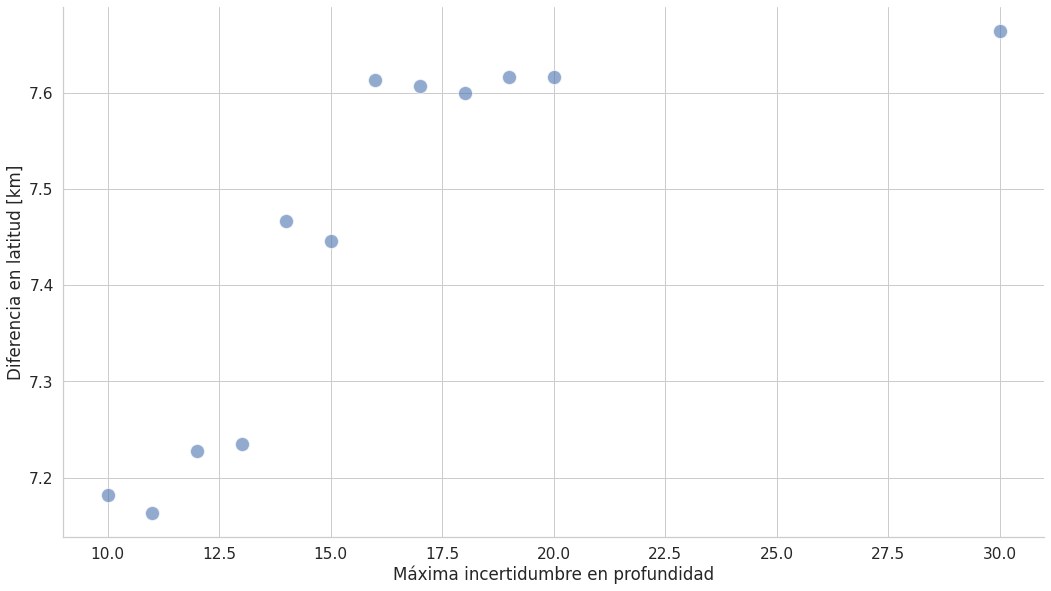

In [115]:
plot_rel('unc', 'lat', df)
plt.ylabel('Diferencia en latitud [km]')
plt.xlabel('Máxima incertidumbre en profundidad')

Text(0.5, 6.8, 'Máxima incertidumbre en profundidad')

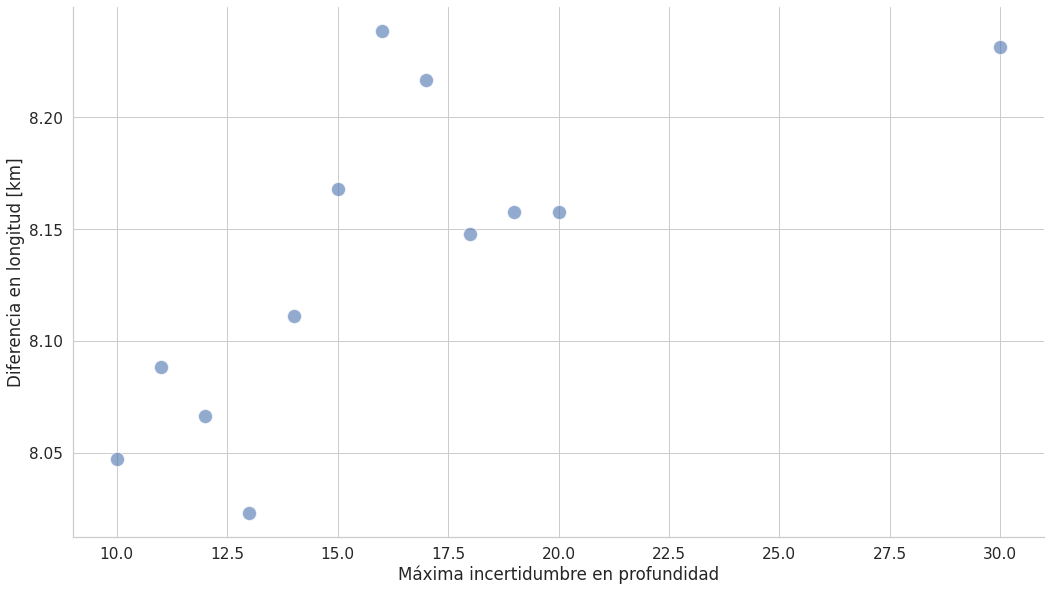

In [116]:
plot_rel('unc', 'lon', df)
plt.ylabel('Diferencia en longitud [km]')
plt.xlabel('Máxima incertidumbre en profundidad')

Text(0.5, 6.8, 'Diferencia radial en localización promedio [km]')

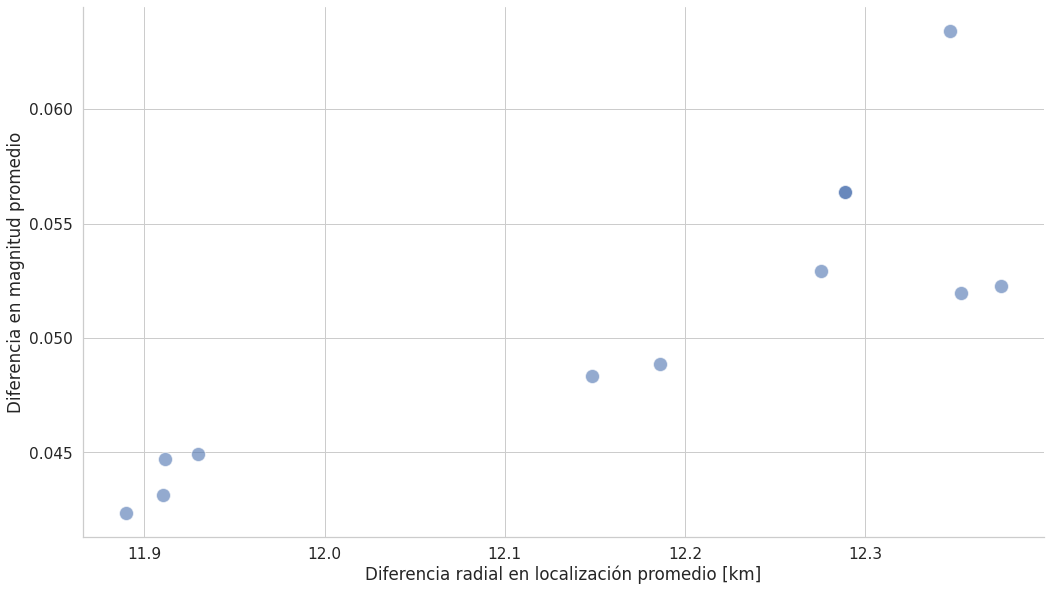

In [117]:
plot_rel('rad', 'mag', df)
plt.ylabel('Diferencia en magnitud promedio')
plt.xlabel('Diferencia radial en localización promedio [km]')